In [2]:
from psaw import PushshiftAPI
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
import os
from collections import Counter
from IPython.display import Image

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') #required for lemmatizer

import tensorflow as tf
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, concatenate, Activation, Input, BatchNormalization, MaxPooling1D, LSTM, Bidirectional, CategoryEncoding
from keras.layers.core import Masking, Dropout, Reshape
from keras.preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from textblob import TextBlob

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zade\anaconda3\envs\py38\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zade\anaconda3\envs\py38\lib\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Zade\anaconda3\envs\py38\lib\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Project Overview  
This project came as the result of attempting to create a regression model to predict the score a given comment might get on a reddit submission.  The original scope was to hopefully build up a regression model for an individual subreddit, then it shrunk to being for a smaller timeframe within an individual subreddit, and finally it ended with this binary 'good' vs. 'bad' posting problem where we label comments with a score less than or equal to one as being a 'bad' comment, and ones with a score over one to be a 'good' comment.  This was decided because comments that are not interacted with in any way remain at one point, and as such it would be hard to call it a 'good' comment if it garners no interaction at all.  So in the end, this became transformed in to a binary classification problem.  We will attempt to model this project via CNNs and RNNs and will assess model performance based on the following: Validation Accuracy, Validation AUC, Time to Fit, and Loss Curves.  We will also do a brief comparison to a non Deep Learning model.  It is assumed that RNNs will perform the best.
There are a myriad of reasons why this type of model might be useful to others including, but not limited to, businesses looking to create content within a given subreddit that would be received well by those who see it - or to promote it further so it is seen by more.  Perhaps they have an ad which is being interacted with already and they wish to interact further with members of the community within the comments of the thread.
While obviously a binary 'good' vs. 'bad' is not quite helpful on its own, it can serve as a bedrock from which further analysis can be done with more depth.  The approach of going subreddit-by-subreddit seems to have been skipped over by many others in an attempt to get some sort of 'best predictor' in general which seemed overly ambitious as I doubt that all subreddits have identical preferences and as such their individuality must be taken in to account within our predictors.    
The data for this was gathered via the Pushshift API which allows for us to customize our selection criteria for comments to be pulled.  In this analysis the largest section of data that we looked at pulled a total of 1,200,000 comments over the course of 2020 from the 'funny' subreddit.  The comments were pulled along with their unique id, the author's name, the time it was created, the subreddit it was from, and the score it recieved.  
The data was pulled month-by-month in an attempt to spread out our data collection in a way that would allow for some time series analyses, but as will be shown later in the notebook, this failed due to the way the API chooses the comments it selects which was not realized in time.  The pull requests also specified the scores to pull from in an attempt to balance the 'good' and 'bad' classes to an extent.  This may impact the model performance but there was a worry of severely undersampling the 'bad' class that outweighed this concern.  
<br />

I would also like to mention that when my original ideas didn't pan out as I wanted, I was inspired by Max Woolf's 'Predicting the Success of a Reddit Submission with Deep Learning and Keras' notebook.  Part of my original reason for including date information was due to this notebook, and in fact the model that will later be referred to as 'original' refers to the model in this notebook which was used as a point of comparison.

<br />

Pushshift API link: https://reddit-api.readthedocs.io/en/latest/  

Max Woolf's Notebook: https://github.com/minimaxir/predict-reddit-submission-success/blob/master/predict_askreddit_submission_success_timing.ipynb

## Gathering the data

Here we set up the timestamps, month-by-month covering 2020.

In [ ]:
# #Init the timestamps (start and end) for consideration
# stimes = [int(dt.datetime(2020, 1, 1).timestamp()), int(dt.datetime(2020, 2, 1).timestamp()),
#          int(dt.datetime(2020, 3, 1).timestamp()), int(dt.datetime(2020, 4, 1).timestamp()),
#          int(dt.datetime(2020, 5, 1).timestamp()), int(dt.datetime(2020, 6, 1).timestamp()),
#          int(dt.datetime(2020, 7, 1).timestamp()), int(dt.datetime(2020, 8, 1).timestamp()),
#          int(dt.datetime(2020, 9, 1).timestamp()), int(dt.datetime(2020, 10, 1).timestamp()),
#          int(dt.datetime(2020, 11, 1).timestamp()), int(dt.datetime(2020, 12, 1).timestamp())]

# etimes = [int(dt.datetime(2020, 1, 31).timestamp()), int(dt.datetime(2020, 2, 29).timestamp())
#          int(dt.datetime(2020, 3, 31).timestamp()), int(dt.datetime(2020, 4, 30).timestamp())
#          int(dt.datetime(2020, 5, 31).timestamp()), int(dt.datetime(2020, 6, 30).timestamp()),
#          int(dt.datetime(2020, 7, 31).timestamp()), int(dt.datetime(2020, 8, 31).timestamp()),
#          int(dt.datetime(2020, 9, 30).timestamp()), int(dt.datetime(2020, 10, 31).timestamp()),
#          int(dt.datetime(2020, 11, 30).timestamp()), int(dt.datetime(2020, 12, 31).timestamp())]

Here we set up the Pushshift API retreival function we use which specifies the details we pull out of the comments that we pull as well as defining which comments we pull from in general.

In [ ]:
# #prep the Pushshift API retreival function
# api = PushshiftAPI()
# def data_prep_comments(subr, start_time, end_time, filters, limit, scorestr):
#     if (len(filters) == 0):
#         filters = ['id', 'author', 'created_utc', 'body', 'subreddit', 'score']
#                    #We set by default some usefull columns 

#     comments = list(api.search_comments(
#         subreddit = subr,       #Subreddit we want to audit
#         after=start_time,       #Start date
#         before=end_time,        #End date
#         filter=filters,         #Column names we want to retrieve
#         score = scorestr,         #set score limits
#         limit=limit))           #Max number of comments
#     return pd.DataFrame(comments) #Return dataframe for analysis

Our actual pulls are commented out below showing how the data was stored initially.  There are three cells, each showing one of the score requirements we set in an attempt to balance our dataset.  Most comments have a score of 1 so the 'bad' class was split in half, half of which required the score to be below 1.

In [ ]:
# sOI_list = ['funny'] #had more than just 'funny' before, narrowed down to this
# filters = [] #keep all features defaulted for now
# limit = 50000 #max num. comments to retrieve for scorestr > 1 
# for sOI in sOI_list:
#     print(f"Starting {sOI} Reading")
#     for i in range(len(stimes)):
#         print(f"Doing {dt.date.fromtimestamp(stimes[i])} to {dt.date.fromtimestamp(etimes[i])}")
#         testdf = data_prep_comments(sOI, stimes[i], etimes[i], filters, limit, scorestr = '>1')
#         testdf.to_csv(f"Comment_Data_Raw/{dt.date.fromtimestamp(stimes[i]).month}_over1_{sOI}_comments_numof_{limit}_{stimes[i]}_to_{etimes[i]}.csv", index = False) #save

In [ ]:
# sOI_list = ['funny']
# filters = [] #keep all features for now
# limit = 25000 #max num. comments to retrieve for scorestr = 1
# for sOI in sOI_list:
#     print(f"Starting {sOI} Reading")
#     for i in range(len(stimes)):
#         print(f"Doing {dt.date.fromtimestamp(stimes[i])} to {dt.date.fromtimestamp(etimes[i])}")
#         testdf = data_prep_comments(sOI, stimes[i], etimes[i], filters, limit, scorestr = '=1')
#         testdf.to_csv(f"Comment_Data_Raw/{dt.date.fromtimestamp(stimes[i]).month}_equal1_{sOI}_comments_numof_{limit}_{stimes[i]}_to_{etimes[i]}.csv", index = False) #save

In [ ]:
# sOI_list = ['funny']
# filters = [] #keep all features for now
# limit = 25000 #max num. comments to retrieve for scorestr < 1
# for sOI in sOI_list:
#     print(f"Starting {sOI} Reading")
#     for i in range(len(stimes)):
#         print(f"Doing {dt.date.fromtimestamp(stimes[i])} to {dt.date.fromtimestamp(etimes[i])}")
#         testdf = data_prep_comments(sOI, stimes[i], etimes[i], filters, limit, scorestr = '<1')
#         testdf.to_csv(f"Comment_Data_Raw/{dt.date.fromtimestamp(stimes[i]).month}_under1_{sOI}_comments_numof_{limit}_{stimes[i]}_to_{etimes[i]}.csv", index = False) #save

In [65]:
#Already saved my 2020 data, read it in here
df = pd.read_csv("funny_2020_cleaned.csv")

In [66]:
df.head()

,author,body,created_utc,id,score,subreddit,Date,BinaryBucket,Hour,Weekday,Day_of_Year,cComment,BodyLen,BodySubjectivity,BodyPolarity,SubjectivityBucket,PolarityBucket,ScaledBodyLen,LengthBucket
0,EggyRepublic,I never seen virus in plural form,1580449087,fg2nlhr,2,funny,2020-01-30,1,23,3,30,never seen virus plural form,7,0.000000,0.000000,0,1,0.003504,0
1,acog,"That stuff is incredible, but I don't get how ...",1580449045,fg2njux,3,funny,2020-01-30,1,23,3,30,stuff incredible dont get everyone describing ...,109,0.700000,0.480000,2,1,0.054555,3
2,MWGLITCH,We're butt buddies!,1580449036,fg2njj2,2,funny,2020-01-30,1,23,3,30,butt buddy,3,0.000000,0.000000,0,1,0.001502,0
3,Lobenz,Have some silver. This is sick shit.,1580448939,fg2nfme,2,funny,2020-01-30,1,23,3,30,silver sick shit,7,0.828571,-0.457143,2,1,0.003504,0
4,AlysonWonderland7,He probably does the same thing to blow up dol...,1580448855,fg2ncac,2,funny,2020-01-30,1,23,3,30,probably thing blow doll teach girlfriend look...,24,0.512500,0.050000,1,1,0.012012,1


In [69]:
df.shape

(1054303, 19)

## About the dataframe  
Because it takes quite a while to do all this pulling the final output was concatenated and saved in to 'funny_2020_cleaned.csv' and read in above.  With that said, the process of how the raw data was transformed in to the above is listed below in the 'Cleaning the Data' section.  
The full dataset is a (1054303, 19) dataframe.  
The columns are listed blow:

In [70]:
df.columns

Index(['author', 'body', 'created_utc', 'id', 'score', 'subreddit', 'Date',
       'BinaryBucket', 'Hour', 'Weekday', 'Day_of_Year', 'cComment', 'BodyLen',
       'BodySubjectivity', 'BodyPolarity', 'SubjectivityBucket',
       'PolarityBucket', 'ScaledBodyLen', 'LengthBucket'],
      dtype='object')

The author, body, created_utc, id, score, and subreddit information were all taken from the API pull request.  The other features were created based off of these original ones.  The process of creating these additional features are shown in the following section(s) of the notebook.

In [76]:
df.describe()

,created_utc,score,BinaryBucket,Hour,Weekday,Day_of_Year,BodyLen,BodySubjectivity,BodyPolarity,SubjectivityBucket,PolarityBucket,ScaledBodyLen,LengthBucket
count,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06
mean,1.594309e+09,4.773615e+00,5.604964e-01,1.473739e+01,2.923292e+00,1.907906e+02,1.816756e+01,3.582868e-01,6.534682e-02,7.173554e-01,1.022833e+00,9.092874e-03,8.597215e-01
std,9.215150e+06,6.091513e+01,4.963269e-01,5.730814e+00,2.056337e+00,1.066715e+02,2.844677e+01,3.345153e-01,2.859555e-01,7.906259e-01,3.198381e-01,1.423762e-02,9.482511e-01
min,1.578191e+09,-7.210000e+02,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.586825e+09,0.000000e+00,0.000000e+00,1.200000e+01,1.000000e+00,1.040000e+02,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.502503e-03,0.000000e+00
50%,1.595254e+09,2.000000e+00,1.000000e+00,1.600000e+01,3.000000e+00,2.020000e+02,1.000000e+01,3.666667e-01,0.000000e+00,1.000000e+00,1.000000e+00,5.005005e-03,1.000000e+00
75%,1.602175e+09,3.000000e+00,1.000000e+00,1.900000e+01,5.000000e+00,2.820000e+02,2.000000e+01,6.000000e-01,1.954545e-01,1.000000e+00,1.000000e+00,1.001001e-02,1.000000e+00
max,1.609394e+09,1.881800e+04,1.000000e+00,2.300000e+01,6.000000e+00,3.650000e+02,1.998000e+03,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,3.000000e+00


While there were many features, only a few were used in our analysis below.  Here are some statistics for these features.

In [79]:
df[['score', 'BinaryBucket', 'SubjectivityBucket', 'PolarityBucket', 'LengthBucket',
   'Hour', 'Weekday', 'Day_of_Year']].describe()

,score,BinaryBucket,SubjectivityBucket,PolarityBucket,LengthBucket,Hour,Weekday,Day_of_Year
count,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06,1.054303e+06
mean,4.773615e+00,5.604964e-01,7.173554e-01,1.022833e+00,8.597215e-01,1.473739e+01,2.923292e+00,1.907906e+02
std,6.091513e+01,4.963269e-01,7.906259e-01,3.198381e-01,9.482511e-01,5.730814e+00,2.056337e+00,1.066715e+02
min,-7.210000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.200000e+01,1.000000e+00,1.040000e+02
50%,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.600000e+01,3.000000e+00,2.020000e+02
75%,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.900000e+01,5.000000e+00,2.820000e+02
max,1.881800e+04,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.300000e+01,6.000000e+00,3.650000e+02


## Cleaning the Data  
#### (Note that the text embeddings happen later, in the 'Modeling' section)

This function takes the dataframe, removes 'AutoMod', 'deleted', and 'removed' posts as well as any duplicates that may have been pulled before it adds the 'Date', 'Hour', 'Weekday', 'Day_of_Year', and 'BinaryBucket' columns and dropping the 'created' and 'd_' columns which we will not need again.  
The BinaryBucket column is our target variable for this project which has a 1 if the score for a given comment has a score over one ('good') and a 0 if it is less than or equal to 1 ('bad')  

In [6]:
def clean_up_df(df):
    df = df[df.author != 'AutoModerator'] #get rid of automod posts
    df.drop_duplicates(inplace = True) #there will be duplicates from the way we got our data, must remove them
    df = df[(df['body'] != "[deleted]") & (df['body'] != '[removed]')] #remove [deleted] comments and [removed] comments
    df['Date'] = df.created_utc.apply(dt.date.fromtimestamp) #get a 'date' column for easier reading.  
    df.drop(labels = ['created', 'd_'], axis = 1, inplace = True) #drop two that we won't be using
    df['BinaryBucket'] = np.where(df.score>1, 1, 0) #when score >1, it's a 1, else it's a 0
    
    df['Hour'] = df.created_utc.apply(lambda x: dt.datetime.fromtimestamp(x).hour) #get the hour column
    df['Weekday'] = df.created_utc.apply(dt.date.fromtimestamp).apply(dt.date.weekday) #get the day of week column
    df['Day_of_Year'] = df.Date.apply(lambda x: dt.date.timetuple(x).tm_yday) #get the day of year column
    
    
    df.reset_index(drop = True, inplace = True) #reset index since we did a lot of moving things around
    return df

This cell initializes a lemmatizer then does some basic text preprocessing including removing whitespace, lowercasing, removing stopwords, etc.

In [7]:
#basic text preprocessor
lemmatizer = WordNetLemmatizer()
def text_preproc(row):
    text = str(row['body'])
    text = text.encode('ascii', errors = 'ignore').decode() #remove non-ascii characters
    text = re.sub(r'\d+', '', text) #remove numbers
    text = text.lower() #set to lowercase
    text = text.strip() #remove whitespace
    text = re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~.\'!?]+','',text) #remove all punctuation 
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #remove URLs
    
    stops = set(stopwords.words('english')) #set of stopwords to compare to
    #following line does quite a bit.  takes words from text, and if they are longer than 1 character and not a stop word then they join them back together
    #using the lemmatized versions of the words in to a new string
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if (word not in stops) and len(word) > 1])
    
    return text

This cell removed any comments which got 'completely cleaned away'.

In [8]:
# df['cComment'] = df.apply(text_preproc, axis = 1)
# df = df[~df.cComment.apply(lambda x: len(x.split()) == 0)]
# df.reset_index(inplace = True)

Here we have a basic function which counts the number of words in a given row.  It returned an error if the cell was, say, blank.  These errors were removed before moving on.

In [9]:
def find_num_words(txt):
    try:
        return(len(re.findall(r'[A-Za-z\']+(?:\`[A-Za-z]+)?', txt)))
    except:
        return(f"Error")

In [10]:
# df['BodyLen'] = df.body.apply(find_num_words)
# df[df.BodyLen == 'Error'] #remove those posts which had no body length. 
# could move above line to clean_up_df() but this is just to show how I did it, would move in the future.

Here we used Textblob to create a 'Subjectivity' and 'Polarity' column within our dataframe, based upon the full text column.  This was inspired by the fact that part of my original project included some sentiment analysis.  While it was too time consuming to do a thorough sentiment analysis in addition to the other work for this project, this was brought in to see if it could have any impact as a feature in leiu of a true sentiment analysis.

In [11]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [ ]:
# df['BodySubjectivity'] = df.body.apply(getSubjectivity)
# df['BodyPolarity'] = df.body.apply(getPolarity)

Here we transformed some features from continuous variables in to categorical variables so as to use them in our models.  The bins were chosen for the subjectivity and polarity based on the fact that they were probabilistic in the first place, leaving only the 'more sure' sides alone and setting the middle ground to a neutral state.  The bins for the length buckets were chosen based on quantiles which are shown in more detail later.

In [12]:
subj_cut_labels = [0, 1, 2] #0 for objective, 1 for neutral, 2 for subjective
subj_cut_bins = [0, 0.35, 0.65, 1]

polar_cut_labels = [0, 1, 2] #0 for negative, 1 for neutral, 2 for positive
polar_cut_bins = [-1, -0.5, 0.5, 1]

len_cut_labels = [0, 1, 2, 3] #0 for shorter, 1 for average, 2 for longer, 3 for super long.  must be 1-hot-encoded in layers later
len_cut_bins = [0, 0.004005, 0.01201202, 0.02002003, 1] #could just do a qcut here but keep as-is in case we change later

In [30]:
# scaler = MinMaxScaler()
# df['ScaledBodyLen'] = scaler.fit_transform(df[['BodyLen']])

In [31]:
# df['SubjectivityBucket'] = pd.cut(df.BodySubjectivity, subj_cut_bins, labels = subj_cut_labels, include_lowest = True)
# df['PolarityBucket'] = pd.cut(df.BodyPolarity, polar_cut_bins, labels = polar_cut_labels, include_lowest = True)
# df['LengthBucket'] = pd.cut(df.ScaledBodyLen, len_cut_bins, labels = len_cut_labels, include_lowest = True) #remember these must be 1-hot encoded later

## EDA 1
#### Begin with smaller subset (Jan-Apr)  
Part of what I wanted to assess in my original project was if trends in the short term applied to the long term, and if smaller subsections of data could be used for quick results that matched up with the results of many times the data.  This spirit was carried to this section of the notebook where I took one third of my full dataset and attempted to model.  These results will be compared to the final, full dataset results later.

In [30]:
#Select the smaller dataset
janthruapr = df[(df['Date'].str.startswith('2020-01')) | (df['Date'].str.startswith('2020-02')) | 
   (df['Date'].str.startswith('2020-03')) | (df['Date'].str.startswith('2020-04'))]

In [31]:
#remove any errors
# janthruapr = janthruapr[~janthruapr['cComment'].isnull()]
# janthruapr.reset_index(inplace = True, drop = True)
#notneeded now that we just pull from full df

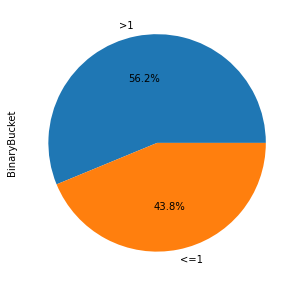

In [33]:
#show class distribution
ax = janthruapr.BinaryBucket.value_counts().plot.pie(labels = [">1", "<=1"],
                                                    autopct = '%1.1f%%', figsize = (5,5))

Text(0, 0.5, 'Freq.')

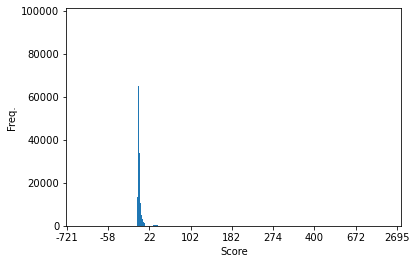

In [34]:
#show raw score distribution
ax = janthruapr.score.value_counts().sort_index(ascending = True).plot(kind = 'bar', rot = 0)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_xlabel("Score")
ax.set_ylabel("Freq.")

Text(0, 0.5, 'Freq.')

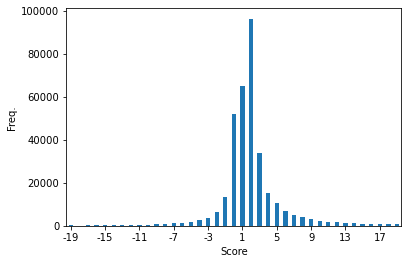

In [68]:
#zoom in on the majority of the scores
ax = janthruapr[(janthruapr.score < 20) & (janthruapr.score > -20)].score.value_counts().sort_index(ascending = True).plot(kind = 'bar', rot = 0)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_xlabel("Score")
ax.set_ylabel("Freq.")

In [36]:
#show raw score quantiles
janthruapr.score.quantile(q = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

0.0    -721.0
0.1      -1.0
0.2       0.0
0.3       1.0
0.4       1.0
0.5       2.0
0.6       2.0
0.7       2.0
0.8       3.0
0.9       6.0
1.0    5231.0
Name: score, dtype: float64

In [37]:
#check correlations of features
corr = janthruapr.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,created_utc,score,BinaryBucket,Hour,Weekday,Day_of_Year,BodyLen,BodySubjectivity,BodyPolarity,SubjectivityBucket,PolarityBucket,ScaledBodyLen,LengthBucket
created_utc,1.000000,-0.002805,0.016207,0.067769,-0.288524,0.999982,0.009706,0.002591,0.008063,0.001968,0.004916,0.009706,0.010641
score,-0.002805,1.000000,0.123830,0.030433,0.019348,-0.002992,0.007746,-0.003710,0.003209,-0.004993,0.003957,0.007746,0.009039
BinaryBucket,0.016207,0.123830,1.000000,0.105476,0.113758,0.015580,-0.036153,-0.022906,0.028364,-0.023588,0.020591,-0.036153,-0.026141
Hour,0.067769,0.030433,0.105476,1.000000,0.000131,0.061714,-0.012165,0.003326,0.007513,0.002870,0.007988,-0.012165,-0.008817
Weekday,-0.288524,0.019348,0.113758,0.000131,1.000000,-0.288671,-0.013301,-0.003084,-0.005226,-0.003243,-0.003343,-0.013301,-0.013254
Day_of_Year,0.999982,-0.002992,0.015580,0.061714,-0.288671,1.000000,0.009784,0.002576,0.008022,0.001955,0.004871,0.009784,0.010700
BodyLen,0.009706,0.007746,-0.036153,-0.012165,-0.013301,0.009784,1.000000,0.166574,-0.002263,0.138034,-0.025403,1.000000,0.742089
BodySubjectivity,0.002591,-0.003710,-0.022906,0.003326,-0.003084,0.002576,0.166574,1.000000,0.157572,0.946765,0.053325,0.166574,0.246692
BodyPolarity,0.008063,0.003209,0.028364,0.007513,-0.005226,0.008022,-0.002263,0.157572,1.000000,0.120243,0.775440,-0.002263,0.001097
SubjectivityBucket,0.001968,-0.004993,-0.023588,0.002870,-0.003243,0.001955,0.138034,0.946765,0.120243,1.000000,0.040443,0.138034,0.206882


From this we can see that there are unfortunately no big correlations present between the score - or it's representation as BinaryBucket - to any of the other features.  We just have to hope our models can pick up something that we can't see here!

In [81]:
janthruapr.BodyLen.quantile(q = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]) #clearly the largest is a bit of an ourlier

0.0       0.0
0.1       3.0
0.2       4.0
0.3       6.0
0.4       8.0
0.5      10.0
0.6      13.0
0.7      17.0
0.8      23.0
0.9      38.0
1.0    1624.0
Name: BodyLen, dtype: float64

Check out the top 10 most common words by frequency after cleaning:

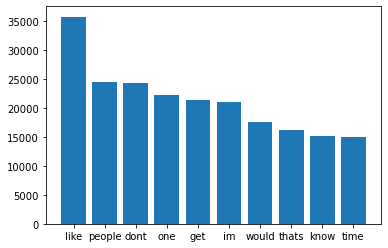

In [137]:
results = Counter()
janthruapr['cComment'].str.lower().str.split().apply(results.update)
y = [count for tag, count in results.most_common(10)]
x = [tag for tag, count in results.most_common(10)]
ax = plt.bar(x, y)

In [174]:
print(f"There are {len(results.keys())} unique words in our cleaned text")

There are 110086 unique words in our cleaned text


## Modeling 1
#### Begin with smaller subset (Jan-Apr)

The choices for our model architecture began by emulating Max Woolf's model which used only an input, embedding, and pooling layer before a sigmoid activation function for the comments branch.  This was then compared to quite a few other architectures such as having many dense layers, having just one additional dense layer, using bidrectional and single-way LSTMs, all of which attempted different pooling strategies and were compared while using different hyperparameters such as the word embeddings, etc.  
All of these were compared until the best of them came out, and then of these best the simplest which achieved the same results were preferred.  It was believed before we started that a single LSTM layer could probably provide quite good results, and the truth was that this was correct.  A single layer LSTM followed by a sigmoid activation function provided results on par with extremely deep networks while fitting quickly.  Adding dropouts, poolings, and dense layers only added to the fitting time without affecting the validation AUC and accuracies much if at all.  
The text embedding functions left below are only for reading in the Glove pre-trained text embeddings, but w2v and bag-of-words approaches were also tested to varying degrees of accuracy among our models.  Glove ended up giving the best, most consistent results and as such it is left in for our report.  
##### A note on embeddings:  
Glove being the best was expected since we chose the glove twitter pre-trained word vectors and we hypothesised that linguistic trends within twitter comments would probably be quite similar to linguistic trends within reddit comments.  Something unexpected was that the 25-day vectors were sufficient to capture all the information that our model could pull out.  Increasing the vector size to even the 200-day pre-trained word vectors had little to no impact on our models.  Since we were unsure, we did end up testing Glove twitter, w2v, and a word-of-bags approach on our models though.

First we have a few functions which prepare our glove embeddings

In [38]:
def prep_embedding(df, vocab_size, maxlen):
    word_tokenizer = Tokenizer(vocab_size) #init tokenizer with the max features we want to see
    word_tokenizer.fit_on_texts(df.cComment) #fit tokenizer on to our df's cleaned comments
#     print(len(word_tokenizer.word_counts)) #not needed, nice to see
    
    comments_tf = word_tokenizer.texts_to_sequences(df.cComment)
    comments_tf = pad_sequences(comments_tf, maxlen = maxlen)
    return comments_tf, word_tokenizer

In [39]:
def get_embeddings(path):#so we can change which embedding we use
    embeddings = {} #empty, to be filled as we read in
    with open(path, 'r', encoding = 'utf8') as f:
        for line in f:
            line_split = line.strip().split(" ")
            vect = np.array(line_split[1:], dtype = float)
            word = line_split[0]
            embeddings[word] = vect
    return embeddings

In [40]:
def get_weights(word_token, embeds, vocab_size):
    weights = np.zeros((vocab_size +1, 25)) #25 as len(embeddings['example_text']) == 25
    for word, i in word_token.word_index.items():
        embedding = embeds.get(word)
        if embedding is not None and i <= vocab_size:
            weights[i] = embedding
    return weights

Here we set some basic hyperparameters which we play with quite a bit in tuning our models

In [41]:
vocab_size = 50000 #set max # features to 50k for now
glove25_path = "GloveTwitterData\\glove.twitter.27B.25d.txt"
glove50_path = "GloveTwitterData\\glove.twitter.27B.50d.txt"
glove100_path = "GloveTwitterData\\glove.twitter.27B.100d.txt"
glove200_path = "GloveTwitterData\\glove.twitter.27B.200d.txt"
embedding_dims = 25 #set from GLOVE
maxlen = 50 #may want to lower, 19 keeps entirety of 90% of our comments but seems a bit long.
batch_size = 256 #can change as needed
date_dims = 64 #dims for our date layers in our model

In [42]:
comments_tf_funny, word_tokenizer_funny = prep_embedding(janthruapr, vocab_size, maxlen)
embeddings_funny = get_embeddings(glove25_path) 
weights_funny = get_weights(word_tokenizer_funny, embeddings_funny, vocab_size)

This cell below defines our model.  Right now this is only showing a very basic LSTM(50) with a 20% dropout (labelled as lstm50_0dense in saved files) as an example.  The formatting for this model and the way that the features are called later are due to Max Woolf's influence.  When comparing our model(s) to his from his paper it was easier to use this formatting.

In [43]:
comments_input_layer = Input(shape = (maxlen,), name = 'comment_input')
comments_embedding_layer = Embedding(vocab_size +1, embedding_dims, weights = [weights_funny])(comments_input_layer)
comments_lstm_layer = LSTM(50, dropout = 0.2)(comments_embedding_layer)

output = Dense(1, activation = 'sigmoid', name = 'output')(comments_lstm_layer) 

In [44]:
model = Model(inputs = [comments_input_layer], outputs = [output])

#loss_weights are how much we weightcomments[0th] vs. the date info [1st].  Set to 1:1 for first pass
model.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0005), metrics = ['accuracy', 'AUC'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 comment_input (InputLayer)  [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 25)            1250025   
                                                                 
 lstm_1 (LSTM)               (None, 50)                15200     
                                                                 
 output (Dense)              (None, 1)                 51        
                                                                 
Total params: 1,265,276
Trainable params: 1,265,276
Non-trainable params: 0
_________________________________________________________________


In [47]:
mycallbacks = [EarlyStopping(monitor = 'val_loss', patience = 3)] #basic early stopping if we get 3 bad epochs

In [48]:
train_janthruapr, test_janthruapr = train_test_split(janthruapr, test_size = 0.2) #split our dataset

comments_train = comments_tf_funny[train_janthruapr.index, :] #get the comments we'll use
binarybucket_train = train_janthruapr.BinaryBucket[train_janthruapr.index] #get the y values

with tf.device('/GPU:0'): #use my GPU
    start = dt.datetime.now()
    history = model.fit(comments_train, binarybucket_train,
                   batch_size = batch_size, epochs = 25, validation_split= 0.2, callbacks = mycallbacks)
    end = dt.datetime.now()

Epoch 1/25
877/877 [==============================] - 13s 11ms/step - loss: 0.6745 - accuracy: 0.5823 - auc: 0.5742 - val_loss: 0.6707 - val_accuracy: 0.5863 - val_auc: 0.5915
Epoch 2/25
877/877 [==============================] - 9s 10ms/step - loss: 0.6676 - accuracy: 0.5927 - auc: 0.5976 - val_loss: 0.6694 - val_accuracy: 0.5884 - val_auc: 0.5983
Epoch 3/25
877/877 [==============================] - 8s 10ms/step - loss: 0.6613 - accuracy: 0.6031 - auc: 0.6162 - val_loss: 0.6646 - val_accuracy: 0.5991 - val_auc: 0.6110
Epoch 4/25
877/877 [==============================] - 8s 10ms/step - loss: 0.6545 - accuracy: 0.6130 - auc: 0.6335 - val_loss: 0.6619 - val_accuracy: 0.6016 - val_auc: 0.6182
Epoch 5/25
877/877 [==============================] - 8s 10ms/step - loss: 0.6475 - accuracy: 0.6203 - auc: 0.6492 - val_loss: 0.6610 - val_accuracy: 0.6041 - val_auc: 0.6229
Epoch 6/25
877/877 [==============================] - 8s 10ms/step - loss: 0.6396 - accuracy: 0.6300 - auc: 0.6648 - val_los

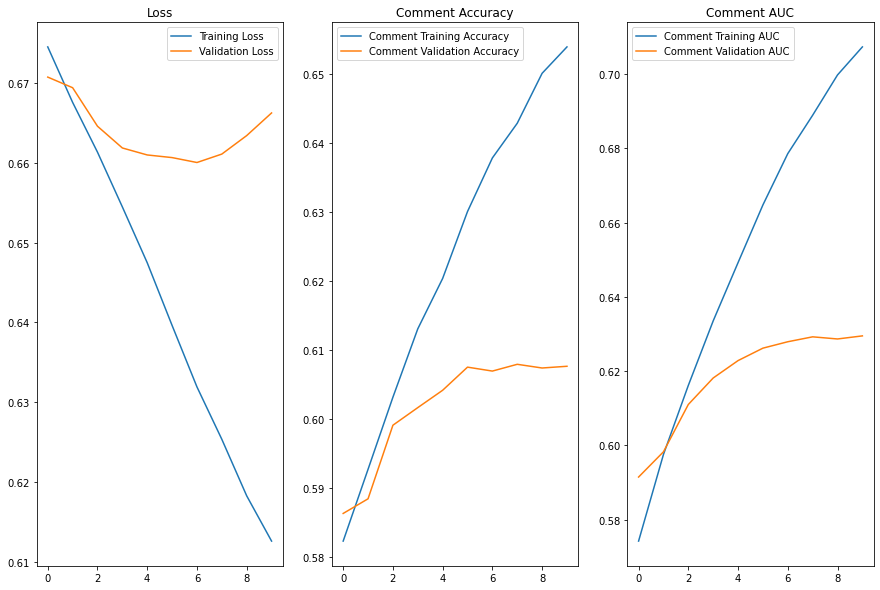

In [49]:
fig, axs = plt.subplots(1, 3, figsize = (15,10))
axs[0].set_title('Loss')
axs[0].plot(history.epoch, history.history['loss'], label = 'Training Loss')
axs[0].plot(history.epoch, history.history['val_loss'], label = 'Validation Loss')
axs[0].legend()

axs[1].set_title('Comment Accuracy')
axs[1].plot(history.epoch, history.history['accuracy'], label = 'Comment Training Accuracy')
axs[1].plot(history.epoch, history.history['val_accuracy'], label = 'Comment Validation Accuracy')
axs[1].legend()

axs[2].set_title('Comment AUC')
axs[2].plot(history.epoch, history.history['auc'], label = 'Comment Training AUC')
axs[2].plot(history.epoch, history.history['val_auc'], label = 'Comment Validation AUC')
axs[2].legend()

In [50]:
print(f"The highest val acc was: {round(np.max(history.history['val_accuracy']),3)}")
print(f"The highest val AUC was: {round(np.max(history.history['val_auc']),3)}")
print(f"Fitting took {end - start}")

The highest val acc was: 0.608
The highest val AUC was: 0.63
Fitting took 0:01:28.804865


Baseline here was ~56.2% acc from our largest class

In [ ]:
#save model images
# plot_model(model, to_file='comment_only_dense50.png')
# plot_model(model, to_file='comment_only_dense50_shapes.png', show_shapes=True)

## Results 1
#### Begin with smaller subset (Jan-Apr)

The above type of procedure was ran through many, many times.  The hyperparameters we tested included the embedding type, the optimizer (and the hyperparameters within a given optimizer), the features used, maxlen, batch size, and of course the model architecture itself.  
While there was quite a bit of time going over this, it was unfortunately my last step to remove the cleaned comments feature itself and assess the model.  This was unfortunate due to the fact that what I had thought was a great model to predict the sucess of a post ended up being just a great model of the API's way of calling in my data!  I was getting accuracies of over 80% when using the 'Hour' and 'Day_of_Year' features.  The fact that they were significant at all should have, in hindsight, immediately alerted me to the issue as there was no reasonable way for the day of the year to matter when looking at only this tiny subset of data.  Unfortunately this meant that I wasted a lot of time assessing models which only modelled the way the API chose to pick its data.  The plot below shows how this 80% accuracy was achieved with just the day of year information due to the way the data was collected.

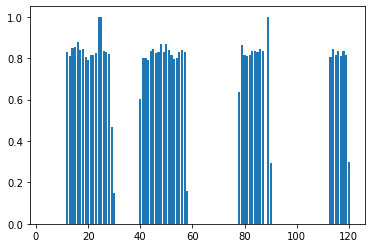

In [53]:
bucket = {}
for day in janthruapr.Day_of_Year.unique():
    bucket[day] = np.mean(janthruapr[janthruapr.Day_of_Year == day].BinaryBucket)
lists = sorted(bucket.items())
x, y = zip(*lists)
plt.bar(x, y)
plt.show()

Because of this issue a lot of work was lost and it was revealed that the true model accuracy was around 61% at best.  Some of the remaining model outcomes are reported below.  The 'Model' column represents the name of the saved model image.  Some of these images are located in the 'miscImages' folder.

|Model|Embedding|Optimizer|Features|MaxValAcc|MaxValAUC|TimeToFit|maxlen|batchsize|
|--|--|--|--|--|--|--|--|--|
|commentonly_original|glove200|adam|cComment|0.606|0.624|00:30|50|256|
|commentonly_original|w2v|adam|cComment|0.600|0.605|00:50|50|256|
|commentonly_original|BOW|adam|cComment|0.567|0.583|01:01|50|256|
|commentonly_original|glove200|sgd|cComment|0.605|0.622|13:21|50|256|
|commentonly_original|glove25|adam|cComment|0.606|0.622|00:29|50|256|
|commentonly_original|glove25|adam|cComment|0.604|0.624|00:50|20|256|
|commentonly_original|glove25|Adam(0.001)|cComment|0.607|0.622|01:23|50|256|
|commentonly_original|glove25|Adam(0.0005)|cComment|0.607|0.623|01:11|50|256|
|commentonly_lstm50_3dense|glove25|Adam(0.0005)|cComment|0.612|0.629|01:33|50|256|
|commentonly_lstm50_2dense|glove25|Adam(0.0005)|cComment|0.611|0.631|01:21|50|256|
|commentonly_lstm100_3dense|glove25|Adam(0.0005)|cComment|0.609|0.624|01:45|50|256|

The first results here use the 'commentonly_original' model which was Max Woolf's mixed model with the date inputs removed.  This same model was used to find out if the embedding type influenced the model performance.  I found my best performance with pre-trained glove embeddings and it was noted that the size of the embeddings used didn't influence performance on this dataset.  Next I looked at different types of optimizers and it was found that adam and sgd performed the best with sgd giving almost identical scores to adam with much nicer loss curves, but at the cost of being much, much slower.  As such the adam optimizer then had its initial learning rate tuned a bit and it was found to give the best results with an initial LR of 0.0005 on average.  Finally a few different model architectures were attempted.  The 'original' refers to the model architecture from the influential Max Woolf reddit prediction model.  It was found to be similar, but a bit behind some of the lstm-based architectures that were attempted here. The maxlen and batchsize parameters were found in some of the many, many other trials that are not listed above.  
The models that ended up being the best here seemed to be tied between commentonly_original and commentonly_lstm50_0dense.  The reason that they appear to be tied is that while the commentonly_original gave a Validation Accuracy of 0.606 and Validation AUC of 0.624, it fit in only 30 seconds.  Compared to the commentonly_lstm50_0dense which acheived a Validation Accuracy of 0.61 and Validation AUC of 0.63 but fitting in 1:10 it is hard to pick.  I think that overall the commentonly_original has a chance at beating out the LSTM just due to it's speed, but I would like to compare these more with the full dataset before I decide which is best overall.

## EDA 2
#### Full 2020 Dataset  
We repeat a lot of the basic EDA done in our smaller subset here and find great agreement between the two.

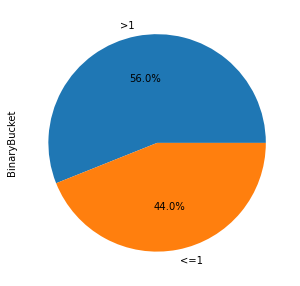

In [55]:
ax = df.BinaryBucket.value_counts().plot.pie(labels = [">1", "<=1"],
                                                    autopct = '%1.1f%%', figsize = (5,5))

Text(0, 0.5, 'Freq.')

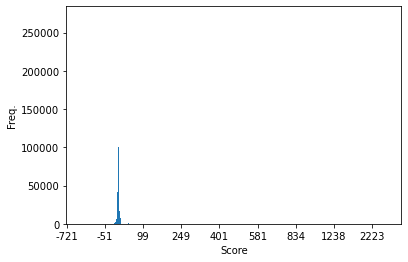

In [56]:
ax = df.score.value_counts().sort_index(ascending = True).plot(kind = 'bar', rot = 0)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_xlabel("Score")
ax.set_ylabel("Freq.")

Text(0, 0.5, 'Freq.')

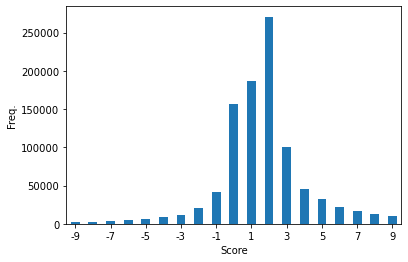

In [57]:
ax = df[(df.score < 10) & (df.score > -10)].score.value_counts().sort_index(ascending = True).plot(kind = 'bar', rot = 0)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_xlabel("Score")
ax.set_ylabel("Freq.")

In [58]:
df.score.quantile(q = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

0.0     -721.0
0.1       -1.0
0.2        0.0
0.3        1.0
0.4        1.0
0.5        2.0
0.6        2.0
0.7        3.0
0.8        4.0
0.9        7.0
1.0    18818.0
Name: score, dtype: float64

In [59]:
corr = df.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,created_utc,score,BinaryBucket,Hour,Weekday,Day_of_Year,BodyLen,BodySubjectivity,BodyPolarity,SubjectivityBucket,PolarityBucket,ScaledBodyLen,LengthBucket
created_utc,1.000000,0.015179,0.005340,-0.057681,0.042664,0.999997,0.016682,0.004351,0.006259,0.003267,0.002105,0.016682,0.018230
score,0.015179,1.000000,0.083792,0.007060,0.017723,0.015160,0.003420,-0.001502,0.001585,-0.001785,0.001010,0.003420,0.004481
BinaryBucket,0.005340,0.083792,1.000000,0.131341,0.032978,0.005046,-0.031366,-0.023567,0.026015,-0.023175,0.019450,-0.031366,-0.023440
Hour,-0.057681,0.007060,0.131341,1.000000,-0.005140,-0.059903,-0.013709,-0.001447,0.006857,-0.000830,0.006992,-0.013709,-0.014891
Weekday,0.042664,0.017723,0.032978,-0.005140,1.000000,0.042644,-0.022963,-0.009767,-0.001255,-0.008374,0.000757,-0.022963,-0.029345
Day_of_Year,0.999997,0.015160,0.005046,-0.059903,0.042644,1.000000,0.016712,0.004354,0.006244,0.003269,0.002089,0.016712,0.018261
BodyLen,0.016682,0.003420,-0.031366,-0.013709,-0.022963,0.016712,1.000000,0.160420,-0.000819,0.131945,-0.022635,1.000000,0.707762
BodySubjectivity,0.004351,-0.001502,-0.023567,-0.001447,-0.009767,0.004354,0.160420,1.000000,0.156022,0.946073,0.049634,0.160420,0.250155
BodyPolarity,0.006259,0.001585,0.026015,0.006857,-0.001255,0.006244,-0.000819,0.156022,1.000000,0.120345,0.773092,-0.000819,0.003093
SubjectivityBucket,0.003267,-0.001785,-0.023175,-0.000830,-0.008374,0.003269,0.131945,0.946073,0.120345,1.000000,0.039471,0.131945,0.208308


In [60]:
df.BodyLen.quantile(q = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]) #clearly the largest is a bit of an ourlier

0.0       0.0
0.1       3.0
0.2       4.0
0.3       6.0
0.4       8.0
0.5      10.0
0.6      13.0
0.7      17.0
0.8      24.0
0.9      40.0
1.0    1998.0
Name: BodyLen, dtype: float64

<AxesSubplot:>

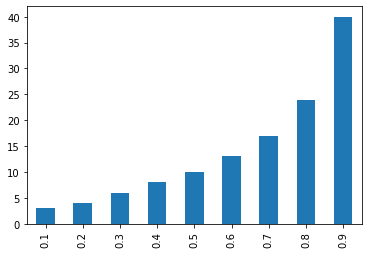

In [62]:
df.BodyLen.quantile(q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).plot(kind = 'bar') #plot just 0-90th percentiles

## Modeling 2
#### Full 2020 Dataset
Since this section basically just re-does the modeling above it is commented out for now.  It is left in to show exactly how the modeling was done if any attempts to re-create it are done (and for possible future work).  It also shows how the multi-input model(s) were built.  
It was again assumed that RNNs made from LSTM layers would perform the best, and it was found that a single LSTM again performed on par with other, more complex models.

In [84]:
# vocab_size = 50000 #set max # features to 50k for now
# embedding_dims = 25 #set from GLOVE
# maxlen = 50 #may want to lower, 19 keeps entirety of 90% of our comments but seems a bit long.
# batch_size = 256 #can change as needed
# date_dims = 64 #dims for our date layers in our model
# onehot_dims = 50

In [96]:
# comments_tf_funny, word_tokenizer_funny = prep_embedding(df, vocab_size, maxlen)
# embeddings_funny = get_embeddings(glove25_path) 
# weights_funny = get_weights(word_tokenizer_funny, embeddings_funny, vocab_size)

In [ ]:
# inputComment = Input(shape = (maxlen,))
# input_subjectivity = Input(shape = (1,))
# input_polarity = Input(shape = (1,))
# input_length = Input(shape = (1,)) 

# #cComments
# x = Embedding(vocab_size +1, embedding_dims, weights = [weights_funny])(inputComment)
# x = LSTM(50, dropout = 0.2)(x)
# x = Dense(1, activation = 'sigmoid')(x)
# x = Model(inputs = inputComment, outputs = x)

# #SubjectivityBucket
# y = CategoryEncoding(num_tokens = 3, output_mode = 'one_hot')(input_subjectivity)
# # y = Reshape((onehot_dims,))(y)
# y = Model(inputs = input_subjectivity, outputs = y)

# #PolarityBucket
# z = CategoryEncoding(num_tokens = 3, output_mode = 'one_hot')(input_polarity)
# # z = Reshape((onehot_dims,))(z)
# z = Model(inputs = input_polarity, outputs = z)

# #LengthBucket
# p = CategoryEncoding(num_tokens = 4, output_mode = 'one_hot')(input_length)
# # p = Reshape((onehot_dims,))(p)
# p = Model(inputs = input_length, outputs = p)

# combined = concatenate([x.output, y.output, z.output, p.output])
# w = Dense(11, activation = 'relu')(combined)
# w = Dense(1, activation = 'sigmoid')(w)

# model = Model(inputs = [x.input, y.input, z.input, p.input], outputs = w)

In [86]:
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy', 'AUC'])
# # model.summary()

In [97]:
# train_df, test_df = train_test_split(df, test_size = 0.2)

# # comments_tr
# comments_train = comments_tf_funny[train_df.index, :]
# subjectivity_train = train_df.SubjectivityBucket[train_df.index]
# polarity_train = train_df.PolarityBucket[train_df.index]
# length_train = train_df.LengthBucket[train_df.index]
# binarybucket_train = train_df.BinaryBucket[train_df.index]

# with tf.device('/GPU:0'): #use my GPU
#     start = dt.datetime.now()
#     history = model.fit([comments_train, subjectivity_train, polarity_train, length_train], binarybucket_train,
#                    batch_size = batch_size, epochs = 100, validation_split= 0.2, callbacks = mycallbacks)
#     end = dt.datetime.now()

In [ ]:
# fig, axs = plt.subplots(1, 3, figsize = (15,10))
# axs[0].set_title('Loss')
# axs[0].plot(history.epoch, history.history['loss'], label = 'Training Loss')
# axs[0].plot(history.epoch, history.history['val_loss'], label = 'Validation Loss')
# axs[0].legend()

# axs[1].set_title('Comment Accuracy')
# axs[1].plot(history.epoch, history.history['accuracy'], label = 'Comment Training Accuracy')
# axs[1].plot(history.epoch, history.history['val_accuracy'], label = 'Comment Validation Accuracy')
# axs[1].legend()

# axs[2].set_title('Comment AUC')
# axs[2].plot(history.epoch, history.history['auc'], label = 'Comment Training AUC')
# axs[2].plot(history.epoch, history.history['val_auc'], label = 'Comment Validation AUC')
# axs[2].legend()

In [98]:
# print(f"The highest val acc was: {round(np.max(history.history['val_accuracy']),3)}")
# print(f"The highest val AUC was: {round(np.max(history.history['val_auc']),3)}")
# print(f"Fitting took {end - start}")

In [ ]:
# plot_model(model, to_file='comPolSubLen2.png')
# plot_model(model, to_file='comPolSubLen2_shapes.png', show_shapes=True)

## Results 2
#### Full 2020 Dataset

(Maxlen and batchsize were also tested here but found to still perform best at 50 and 256 respectively and as such are not included in the chart.)  
Remember that the baseline is now 56.0% (0.2% lower than before)

|Model|Embedding|Optimizer|Features|MaxValAcc|MaxValAUC|TimeToFit|
|--|--|--|--|--|--|--|
|commentonly_original|glove200|adam|cComment|0.601|0.617|02:54|
|commentonly1|glove200|adam|cComment|0.603|0.618|03:36|
|commentonly1|glove200|adam|cComment|0.608|0.626|02:38|
|commentonly2|glove200|adam|cComment|0.609|0.626|02:03|
|commentonly2|glove25|adam|cComment|0.609|0.626|02:39|
|commentonly7|glove25|adam|cComment|0.610|0.627|03:13|
|comPolSubLen1|glove25|adam|cComment, SubjectivityBucket, PolarityBucket, LengthBucket|0.61|0.626|03:22|
|comPolSubLen5|glove25|adam|cComment, SubjectivityBucket, PolarityBucket, LengthBucket|0.609|0.626|03:18|

Using the full dataset we see that the addition of Polarity, Subjectivity, and Length have seemingly no effect, at least with the buckets that were tested for these models.  Using only our cleaned comments gave similar results and fitted a bit quicker.  Noting that commentonly2 involved just one LSTM layer (with a 20% dropout as a LSTM hyperparameter), we see that again a simple model performs the best.  Adding on more layers served only to increase fitting time while leaving our Validation Accuracy and Validation AUC values stagnant.  
One other metric that we can use to evaluate our models (other than the accuracy, AUC, complexity, and time to fit) that we haven't touched on much yet is the loss curve plots produced from our modeling routine.  We have attempted so many models that it would be combersome to include all the outputs, but we can draw attention to one interesting facet of this criteron here.  

In [144]:
import matplotlib.image as mpimg

In [145]:
img0 = mpimg.imread("miscImages/commentonly5_adam1e-4_better_curve_example.png")
img1 = mpimg.imread("miscImages/commentonly5_adamDefault_worse_curve_example.png")
img2 = mpimg.imread("miscImages/commentonly5_sgdDefault_great_example.png")

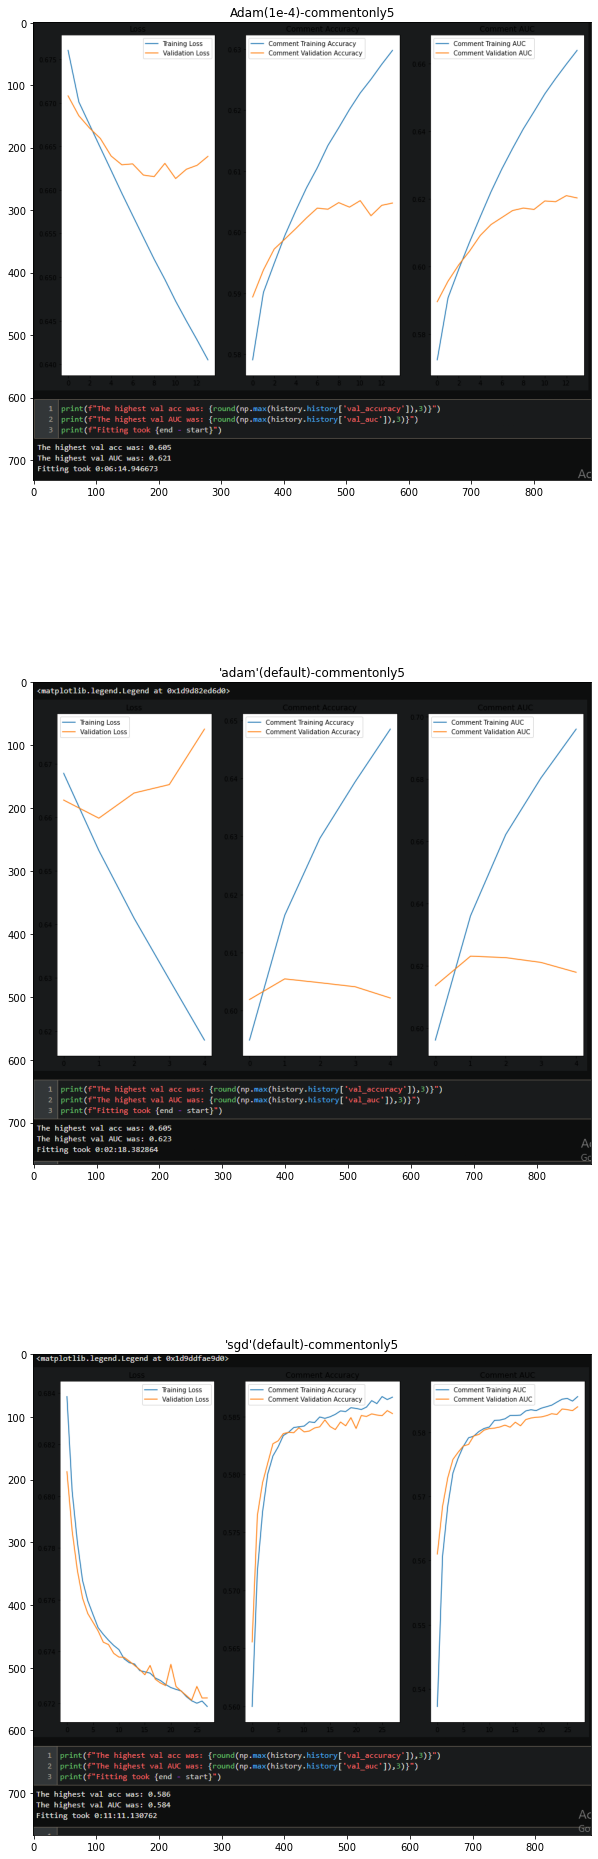

In [154]:
fig, axs = plt.subplots(3, 1, figsize = (10,35))
axs[0].set_title("Adam(1e-4)-commentonly5")
axs[0].imshow(img0)
axs[1].set_title("\'adam\'(default)-commentonly5")
axs[1].imshow(img1)
axs[2].set_title("\'sgd\'(default)-commentonly5")
axs[2].imshow(img2)

Above we show three loss curves associated with three different optimizers used on the same model.  When choosing our best model(s) we also looked at these loss curves and assessed the best of them.  Clearly in this case when comparing an Adam(1e-4) (top), 'adam'(default) (middle), and 'sgd'(default) (bottom), we find that the best loss curve comes from the Adam(1e-4) model here since the 'sgd'(default) result is both unrealistic looking and leads to worse model performance over a longer period of time.  Of course that isn't to say that this was the absolute best loss curve we found, but it does illustrate some of the variations that we often saw when comparing loss curves within models but between optimizers.  

Our best model for the full dataset was labeled as 'commentonly2' and it had the following model architecture and loss curve with our best hyperparameters:

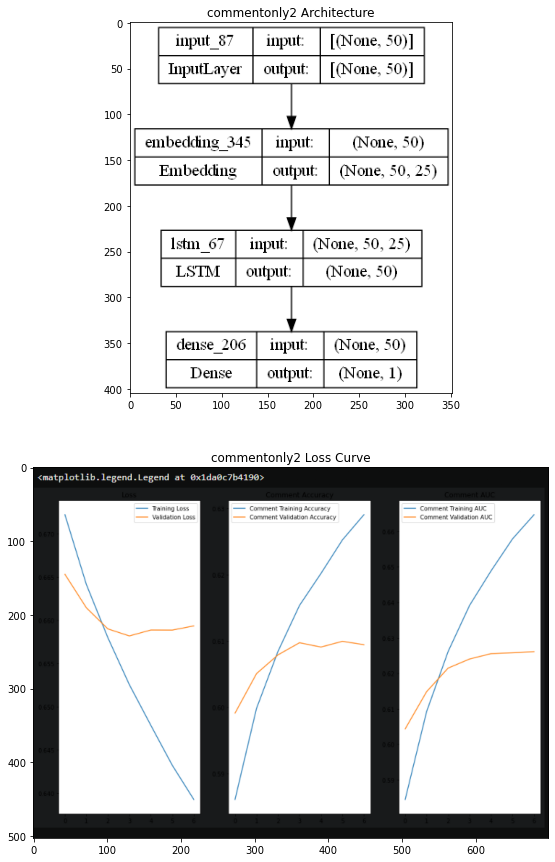

In [170]:
fig, axs = plt.subplots(2,1, figsize = (15, 15))
axs[0].set_title("commentonly2 Architecture")
axs[0].imshow(mpimg.imread('miscImages/commentonly2_shapes.png'))
axs[1].set_title("commentonly2 Loss Curve")
axs[1] = plt.imshow(mpimg.imread('miscImages/commentonly2_loss_example.png'))

When using the glove25 embeddings and an 'adam'(default) optimizer it resulted in a maximum validation accuracy of 0.609 and a maximum validation AUC of 0.626.  The fitting time took only 2:39.  The loss curve was relatively nice with a slight upturn at the end.  Adding in more complex optimization routines such as having the LR decrease on plateau via an early stopping routine produced similar results in accuracy/AUC but with a large increase in fitting times for only marginally better loss curves.  As such this is our chosen final, best model for the full dataset and it used only the 'cComments' feature to achieve this.

## Comparison to non deep learning method
#### Full 2020 Dataset

Finally before our conclusion we attempt a non-DL method to see just how much 'extra' information our DL model pulls from the comments as compared to a relatively less complex approach.  The actual results are not printed here as it took quite a bit to go through all of the gridsearch results, but the final results are included as an image below.

In [ ]:
# #first try a SGDClassifier with just the text data
# train_df, test_df = train_test_split(df, test_size = 0.2)
# comments_train = comments_tf_funny[train_df.index, :]
# binarybucket_train = train_df.BinaryBucket[train_df.index]

In [ ]:
# print("Starting Fitting")
# start = dt.datetime.now()
# clf = SGDClassifier().fit(comments_train, binarybucket_train)
# end = dt.datetime.now()
# print(f"Fitting Took {end - start}")

In [ ]:
# comments_test = comments_tf_funny[test_startbig.index, :]
# predicted = clf.predict(comments_test)
# binarybucket_test = test_startbig.BinaryBucket[test_startbig.index]
# acc = np.mean(predicted == binarybucket_test)
# acc

With gridsearching

In [ ]:
# text_clf = Pipeline([('vect', CountVectorizer()),
#                     ('tfidf', TfidfTransformer()),
#                     ('clf', SGDClassifier())])

# params = {'vect__ngram_range': [(1,1), (1,2)],
#          'tfidf__use_idf': (True, False),
#          'clf__alpha': (1e-1, 1e-2, 1e-3, 1e-4, 1e-5)}

# train_startbig, test_startbig = train_test_split(startbig, test_size = 0.2)
# comments_train_clf = train_startbig.cComment[train_startbig.index]
# binarybucket_train_clf = train_startbig.BinaryBucket[train_startbig.index]


# gridsearch_clf = GridSearchCV(text_clf, params, scoring = ['accuracy', 'roc_auc'], cv = 5, verbose = 2, refit = 'accuracy')
# gridsearch_clf = gridsearch_clf.fit(comments_train_clf, binarybucket_train_clf)

In [ ]:
# print(gridsearch_clf.best_score_, gridsearch_clf.best_params_)

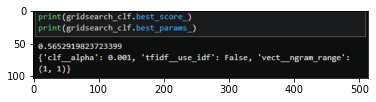

In [160]:
plt.imshow(mpimg.imread("gridsearch_results.png"))

Clearly our deep learning model captures more information from our cleaned up comments- and it's much faster too!

## Conclusions

In this project we have found a slightly successful model to predict if a reddit comment in the 'funny' subreddit in 2020 would succeed or fail.  From our brief dive in to the applicability of this model to larger timeframes we see that models which succeeded at a smaller timeframe also performed well at a larger timeframe, although a bit below optimally.  We also see that the maximum validation AUC and accuracy remain relatively stable even when tripling the amount of data that the model receives.  This seems to imply that our model has gotten just about all the information it can out of these cleaned up comments and it is up to us to find or create additional features to improve our model performance.  
Something that would benefit our model greatly would be to revisit the way that we procured our data with the Pushshift API and attempt to find a way to pull in data more evenly allowing for some in depth analysis on the time data that we pulled.  This would allow us to model possible temporal trends and add these temporal features to our models.  
Another feature that would be quite interesting relates to my original project proposal which included creating a model for the sentiment of a given comment within a given subreddit and to use this comment sentiment, along with the sentiment of the post, and their possible differences, as features.  I was not sure which would give the greatest impact, but I believe that this has a definite possibility to allow for future insights.  For example, I would expect a positive comment on a positive post in 'funny' to, on average, get more karma than say a positive comment on a negative post in 'news'.  The tones of the subreddits are just different.  

Future work that doesn't involve a whole new project could be to incorporate additional subreddits in to our current modeling procedures and to see if there are trends between subreddits.  Another thing could be to simply add in more data.  Or perhaps adding in more, custom stopwords in addition to the default stopwords we already included could allow us to get more information out of our cleaned comments without us having to even do any more modeling.  

Overall this project serves as a very light dip in to the analysis of reddit comments.  I believe that the best way to carry on this project in the future would be to look in to the way the data is pulled and get useable time-related information.  With what we have already done we have a basic outline of many hyperparameters that work and ones which don't which would streamline future modeling choices and vastly reduce the time it would take to test new architectures and hyperparameters.